Perform Classification with K-nearest Neighbor Algorithm.

# **Processing the Data**

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

df = pd.read_csv("https://www.dropbox.com/s/ng1zijfpsayzseu/pokedex_%28Update_04.21%29_3.csv?dl=1",index_col=0,encoding= 'unicode_escape')

**Drop features that are clearly not needed.**

In [3]:
df = df.drop(labels = ['pokedex_number','name','german_name','japanese_name','generation','species','type_number','abilities_number',
                       'ability_1','ability_2','ability_hidden','base_friendship','percentage_male','egg_type_number','egg_type_2',
                       'against_normal','against_fire','against_water','against_electric','against_grass','against_ice','against_fight',
                       'against_poison','against_ground','against_flying','against_psychic','against_bug','against_rock','against_ghost',
                       'against_dragon','against_dark','against_steel','against_fairy'], axis = 1)
df = df.drop(1033) # remove eternamax because it is a huge outlier

**Preview the distribution of pokemon per type.**

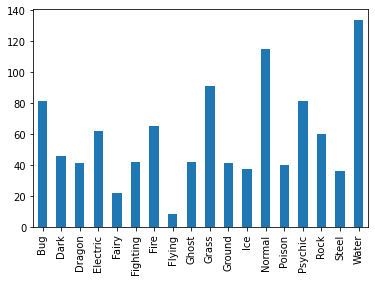

In [4]:
df['type_1'].value_counts().sort_index().plot.bar()

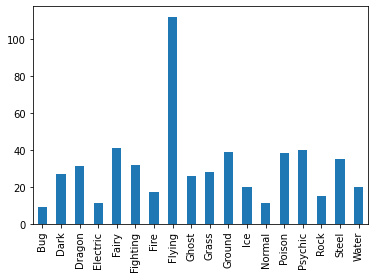

In [5]:
df['type_2'].value_counts().sort_index().plot.bar()

In [6]:
df.describe()

,height_m,weight_kg,total_points,hp,attack,defense,sp_attack,sp_defense,speed,catch_rate,base_experience,egg_cycles
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,1.279598,71.216571,438.696360,69.890805,80.443487,74.502874,72.981801,72.128352,68.749042,92.919540,155.250000,31.393678
std,1.385909,132.259911,120.188908,26.061943,32.430642,30.799182,32.721971,27.568146,30.165066,75.916006,80.077143,30.389722
min,0.100000,0.100000,175.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,3.000000,36.000000,5.000000
25%,0.600000,9.000000,330.000000,50.000000,55.000000,50.000000,50.000000,50.000000,45.000000,45.000000,67.000000,20.000000
50%,1.000000,29.500000,458.000000,68.000000,77.000000,70.000000,65.000000,70.000000,65.000000,60.000000,161.000000,20.000000
75%,1.600000,70.500000,515.000000,82.000000,100.000000,90.000000,95.000000,90.000000,90.000000,127.000000,201.500000,25.000000
max,20.000000,999.900000,780.000000,255.000000,190.000000,230.000000,194.000000,230.000000,200.000000,255.000000,608.000000,120.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044 entries, 0 to 1044
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   status           1044 non-null   object 
 1   type_1           1044 non-null   object 
 2   type_2           552 non-null    object 
 3   height_m         1044 non-null   float64
 4   weight_kg        1044 non-null   float64
 5   total_points     1044 non-null   int64  
 6   hp               1044 non-null   int64  
 7   attack           1044 non-null   int64  
 8   defense          1044 non-null   int64  
 9   sp_attack        1044 non-null   int64  
 10  sp_defense       1044 non-null   int64  
 11  speed            1044 non-null   int64  
 12  catch_rate       1044 non-null   int64  
 13  base_experience  1044 non-null   int64  
 14  growth_rate      1044 non-null   object 
 15  egg_type_1       1044 non-null   object 
 16  egg_cycles       1044 non-null   int64  
dtypes: float64(2),

# **Make 3 variations of the dataset: df1, df2, df3**

1.One uses only type_1 and drops type_2<br>2.Second removes all pokemon with a second type<br>3.Third dupes pokemon with two types into two datapoints with the different types (what we did originally) 

**Dataset #1: of only type_1**

In [8]:
df1 = df.drop(labels=['type_2'],axis=1)
df1.info() # 1044 entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044 entries, 0 to 1044
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   status           1044 non-null   object 
 1   type_1           1044 non-null   object 
 2   height_m         1044 non-null   float64
 3   weight_kg        1044 non-null   float64
 4   total_points     1044 non-null   int64  
 5   hp               1044 non-null   int64  
 6   attack           1044 non-null   int64  
 7   defense          1044 non-null   int64  
 8   sp_attack        1044 non-null   int64  
 9   sp_defense       1044 non-null   int64  
 10  speed            1044 non-null   int64  
 11  catch_rate       1044 non-null   int64  
 12  base_experience  1044 non-null   int64  
 13  growth_rate      1044 non-null   object 
 14  egg_type_1       1044 non-null   object 
 15  egg_cycles       1044 non-null   int64  
dtypes: float64(2), int64(10), object(4)
memory usage: 138.7+ KB


Dataset 2: Pokemon with second type removed

In [9]:
df2_mask = df['type_2'].isnull()
df2 = df[df2_mask].drop(labels=['type_2'],axis=1) # also remove type_2 column
df2.info() # 492 entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492 entries, 4 to 1041
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   status           492 non-null    object 
 1   type_1           492 non-null    object 
 2   height_m         492 non-null    float64
 3   weight_kg        492 non-null    float64
 4   total_points     492 non-null    int64  
 5   hp               492 non-null    int64  
 6   attack           492 non-null    int64  
 7   defense          492 non-null    int64  
 8   sp_attack        492 non-null    int64  
 9   sp_defense       492 non-null    int64  
 10  speed            492 non-null    int64  
 11  catch_rate       492 non-null    int64  
 12  base_experience  492 non-null    int64  
 13  growth_rate      492 non-null    object 
 14  egg_type_1       492 non-null    object 
 15  egg_cycles       492 non-null    int64  
dtypes: float64(2), int64(10), object(4)
memory usage: 65.3+ KB


Dataset 3: Dupe pokemons with second type

In [10]:
without_type2 = df.type_2.isna()
df_withtype2 = df[~without_type2]
df_withtype2 = df_withtype2.drop(labels=['type_1'], axis = 1)
df_withtype2 = df_withtype2.rename({'type_2': 'type_1'}, axis=1)
df3 = pd.concat([df, df_withtype2], ignore_index=True)
df3 = df3.drop(labels=['type_2'], axis = 1)
df3.info() # 1596 entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596 entries, 0 to 1595
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   status           1596 non-null   object 
 1   type_1           1596 non-null   object 
 2   height_m         1596 non-null   float64
 3   weight_kg        1596 non-null   float64
 4   total_points     1596 non-null   int64  
 5   hp               1596 non-null   int64  
 6   attack           1596 non-null   int64  
 7   defense          1596 non-null   int64  
 8   sp_attack        1596 non-null   int64  
 9   sp_defense       1596 non-null   int64  
 10  speed            1596 non-null   int64  
 11  catch_rate       1596 non-null   int64  
 12  base_experience  1596 non-null   int64  
 13  growth_rate      1596 non-null   object 
 14  egg_type_1       1596 non-null   object 
 15  egg_cycles       1596 non-null   int64  
dtypes: float64(2), int64(10), object(4)
memory usage: 199.6+ KB


# **Make 2 versions of each dataset: A (numerical) and B (catergorical)**

There should be 6 datasets total:<br>
df1a, df1b:  dataset #1, 1a is numerical and 1b is categorical<br>
df2a, df2b:  dataset #2, 2a is numerical and 2b is categorical<br>
df3a, df3b:  dataset #3, 3a is numerical and 3b is categorical<br>

**Create the numerical versions of the 3 datasets by converting categorical features to binary via one hot encoding.**

In [11]:
# converting df1 into df1a
df_r_Binary1 = df1.loc[: , ['status']].astype('category')
df_r_Binary1 = pd.get_dummies(df_r_Binary1)

df_r_Binary2 = df1.loc[: , ['egg_type_1']].astype('category')
df_r_Binary2 = pd.get_dummies(df_r_Binary2)

df_r_Binary3 = df1.loc[: , ['growth_rate']].astype('category')
df_r_Binary3 = pd.get_dummies(df_r_Binary3)

df1a = df1.drop(['status','egg_type_1','growth_rate'], axis=1).join(df_r_Binary1).join(df_r_Binary2).join(df_r_Binary3)
df1a# number of columns increased from 16 --> 38 because 3 categorical columns have been split into binary columns


,type_1,height_m,weight_kg,total_points,hp,attack,defense,sp_attack,sp_defense,speed,catch_rate,base_experience,egg_cycles,status_Legendary,status_Mythical,status_Normal,status_Sub Legendary,egg_type_1_Amorphous,egg_type_1_Bug,egg_type_1_Ditto,egg_type_1_Dragon,egg_type_1_Fairy,egg_type_1_Field,egg_type_1_Flying,egg_type_1_Grass,egg_type_1_Human-Like,egg_type_1_Mineral,egg_type_1_Monster,egg_type_1_Undiscovered,egg_type_1_Water 1,egg_type_1_Water 2,egg_type_1_Water 3,growth_rate_Erratic,growth_rate_Fast,growth_rate_Fluctuating,growth_rate_Medium Fast,growth_rate_Medium Slow,growth_rate_Slow
0,Grass,0.7,6.9,318,45,49,49,65,65,45,45,64,20,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Grass,1.0,13.0,405,60,62,63,80,80,60,45,142,20,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,Grass,2.0,100.0,525,80,82,83,100,100,80,45,236,20,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3,Grass,2.4,155.5,625,80,100,123,122,120,80,45,281,20,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Fire,0.6,8.5,309,39,52,43,60,50,65,45,62,20,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,Ice,2.2,800.0,580,100,145,130,65,110,30,3,290,120,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1041,Ghost,2.0,44.5,580,100,65,60,145,80,130,3,290,120,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1042,Psychic,1.1,7.7,500,100,80,80,80,80,80,3,250,120,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1043,Psychic,2.4,809.1,680,100,165,150,85,130,50,3,340,120,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [12]:
hp_scaled = preprocessing.scale(df1a.hp)
attack_scaled = preprocessing.scale(df1a.attack)
defense_scaled = preprocessing.scale(df1a.defense)
sp_attack_scaled = preprocessing.scale(df1a.sp_attack)
sp_defense_scaled = preprocessing.scale(df1a.sp_defense)
speed_scaled = preprocessing.scale(df1a.speed)
height_m_scaled = preprocessing.scale(df1a.height_m)
weight_kg_scaled = preprocessing.scale(df1a.weight_kg)
catch_rate_scaled = preprocessing.scale(df1a.catch_rate)
base_experience_scaled = preprocessing.scale(df1a.base_experience)
egg_cycles_scaled = preprocessing.scale(df1a.egg_cycles)

In [13]:
df1a['hp_scaled'] = hp_scaled
df1a['attack_scaled'] = attack_scaled
df1a['defense_scaled'] = defense_scaled
df1a['sp_attack_scaled'] = sp_attack_scaled
df1a['sp_defense_scaled'] = sp_defense_scaled
df1a['speed_scaled'] = speed_scaled
df1a['height_m_scaled'] = height_m_scaled
df1a['weight_kg_scaled'] = weight_kg_scaled
df1a['catch_rate_scaled'] = catch_rate_scaled
df1a['base_experience_scaled'] = base_experience_scaled
df1a['egg_cycles_scaled'] = egg_cycles_scaled

df1a = df1a.drop(labels = ['height_m', 'weight_kg', 'catch_rate','base_experience', 'egg_cycles', 'hp', 'attack','defense','sp_attack','sp_defense','speed'], axis = 1) 
df1a.info()
df1a.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044 entries, 0 to 1044
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   type_1                   1044 non-null   object 
 1   total_points             1044 non-null   int64  
 2   status_Legendary         1044 non-null   uint8  
 3   status_Mythical          1044 non-null   uint8  
 4   status_Normal            1044 non-null   uint8  
 5   status_Sub Legendary     1044 non-null   uint8  
 6   egg_type_1_Amorphous     1044 non-null   uint8  
 7   egg_type_1_Bug           1044 non-null   uint8  
 8   egg_type_1_Ditto         1044 non-null   uint8  
 9   egg_type_1_Dragon        1044 non-null   uint8  
 10  egg_type_1_Fairy         1044 non-null   uint8  
 11  egg_type_1_Field         1044 non-null   uint8  
 12  egg_type_1_Flying        1044 non-null   uint8  
 13  egg_type_1_Grass         1044 non-null   uint8  
 14  egg_type_1_Human-Like   

,type_1,total_points,status_Legendary,status_Mythical,status_Normal,status_Sub Legendary,egg_type_1_Amorphous,egg_type_1_Bug,egg_type_1_Ditto,egg_type_1_Dragon,egg_type_1_Fairy,egg_type_1_Field,egg_type_1_Flying,egg_type_1_Grass,egg_type_1_Human-Like,egg_type_1_Mineral,egg_type_1_Monster,egg_type_1_Undiscovered,egg_type_1_Water 1,egg_type_1_Water 2,egg_type_1_Water 3,growth_rate_Erratic,growth_rate_Fast,growth_rate_Fluctuating,growth_rate_Medium Fast,growth_rate_Medium Slow,growth_rate_Slow,hp_scaled,attack_scaled,defense_scaled,sp_attack_scaled,sp_defense_scaled,speed_scaled,height_m_scaled,weight_kg_scaled,catch_rate_scaled,base_experience_scaled,egg_cycles_scaled
0,Grass,318,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.955521,-0.970026,-0.828434,-0.244045,-0.258696,-0.787680,-0.418408,-0.486522,-0.63152,-1.140072,-0.375098
1,Grass,405,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.379693,-0.568978,-0.373659,0.214583,0.285671,-0.290178,-0.201840,-0.440379,-0.63152,-0.165545,-0.375098
2,Grass,525,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.388077,0.048018,0.276020,0.826086,1.011494,0.373158,0.520054,0.217732,-0.63152,1.008886,-0.375098
3,Grass,625,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.388077,0.603315,1.575378,1.498739,1.737316,0.373158,0.808812,0.637561,-0.63152,1.571113,-0.375098
4,Fire,309,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.185852,-0.877476,-1.023338,-0.396921,-0.803063,-0.124344,-0.490597,-0.474419,-0.63152,-1.165060,-0.375098


In [14]:
# converting df2 into df2a
df_r_Binary1 = df2.loc[: , ['status']].astype('category')
df_r_Binary1 = pd.get_dummies(df_r_Binary1)
df_r_Binary2 = df2.loc[: , ['egg_type_1']].astype('category')
df_r_Binary2 = pd.get_dummies(df_r_Binary2)
df_r_Binary3 = df2.loc[: , ['growth_rate']].astype('category')
df_r_Binary3 = pd.get_dummies(df_r_Binary3)

df2a = df2.drop(['status','egg_type_1','growth_rate'], axis=1).join(df_r_Binary1).join(df_r_Binary2).join(df_r_Binary3)
df2a # number of columns increased from 16 --> 38 because 3 categorical columns have been split into binary columns

,type_1,height_m,weight_kg,total_points,hp,attack,defense,sp_attack,sp_defense,speed,catch_rate,base_experience,egg_cycles,status_Legendary,status_Mythical,status_Normal,status_Sub Legendary,egg_type_1_Amorphous,egg_type_1_Bug,egg_type_1_Ditto,egg_type_1_Dragon,egg_type_1_Fairy,egg_type_1_Field,egg_type_1_Flying,egg_type_1_Grass,egg_type_1_Human-Like,egg_type_1_Mineral,egg_type_1_Monster,egg_type_1_Undiscovered,egg_type_1_Water 1,egg_type_1_Water 2,egg_type_1_Water 3,growth_rate_Erratic,growth_rate_Fast,growth_rate_Fluctuating,growth_rate_Medium Fast,growth_rate_Medium Slow,growth_rate_Slow
4,Fire,0.6,8.5,309,39,52,43,60,50,65,45,62,20,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,Fire,1.1,19.0,405,58,64,58,80,65,80,45,142,20,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9,Water,0.5,9.0,314,44,48,65,50,64,43,45,63,20,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
10,Water,1.0,22.5,405,59,63,80,65,80,58,45,142,20,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
11,Water,1.6,85.5,530,79,83,100,85,105,78,45,239,20,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,Fighting,0.6,12.0,385,60,90,60,53,50,72,3,77,120,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1038,Electric,1.2,145.0,580,80,100,50,100,50,200,3,290,120,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1039,Dragon,2.1,200.0,580,200,100,50,100,50,80,3,290,120,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1040,Ice,2.2,800.0,580,100,145,130,65,110,30,3,290,120,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [15]:
hp_scaled = preprocessing.scale(df2a.hp)
attack_scaled = preprocessing.scale(df2a.attack)
defense_scaled = preprocessing.scale(df2a.defense)
sp_attack_scaled = preprocessing.scale(df2a.sp_attack)
sp_defense_scaled = preprocessing.scale(df2a.sp_defense)
speed_scaled = preprocessing.scale(df2a.speed)
height_m_scaled = preprocessing.scale(df2a.height_m)
weight_kg_scaled = preprocessing.scale(df2a.weight_kg)
catch_rate_scaled = preprocessing.scale(df2a.catch_rate)
base_experience_scaled = preprocessing.scale(df2a.base_experience)
egg_cycles_scaled = preprocessing.scale(df2a.egg_cycles)

In [16]:
df2a['hp_scaled'] = hp_scaled
df2a['attack_scaled'] = attack_scaled
df2a['defense_scaled'] = defense_scaled
df2a['sp_attack_scaled'] = sp_attack_scaled
df2a['sp_defense_scaled'] = sp_defense_scaled
df2a['speed_scaled'] = speed_scaled
df2a['height_m_scaled'] = height_m_scaled
df2a['weight_kg_scaled'] = weight_kg_scaled
df2a['catch_rate_scaled'] = catch_rate_scaled
df2a['base_experience_scaled'] = base_experience_scaled
df2a['egg_cycles_scaled'] = egg_cycles_scaled

df2a = df2a.drop(labels = ['height_m', 'weight_kg', 'catch_rate','base_experience', 'egg_cycles', 'hp', 'attack','defense','sp_attack','sp_defense','speed'], axis = 1) 
df2a.info()
df2a.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492 entries, 4 to 1041
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   type_1                   492 non-null    object 
 1   total_points             492 non-null    int64  
 2   status_Legendary         492 non-null    uint8  
 3   status_Mythical          492 non-null    uint8  
 4   status_Normal            492 non-null    uint8  
 5   status_Sub Legendary     492 non-null    uint8  
 6   egg_type_1_Amorphous     492 non-null    uint8  
 7   egg_type_1_Bug           492 non-null    uint8  
 8   egg_type_1_Ditto         492 non-null    uint8  
 9   egg_type_1_Dragon        492 non-null    uint8  
 10  egg_type_1_Fairy         492 non-null    uint8  
 11  egg_type_1_Field         492 non-null    uint8  
 12  egg_type_1_Flying        492 non-null    uint8  
 13  egg_type_1_Grass         492 non-null    uint8  
 14  egg_type_1_Human-Like    

,type_1,total_points,status_Legendary,status_Mythical,status_Normal,status_Sub Legendary,egg_type_1_Amorphous,egg_type_1_Bug,egg_type_1_Ditto,egg_type_1_Dragon,egg_type_1_Fairy,egg_type_1_Field,egg_type_1_Flying,egg_type_1_Grass,egg_type_1_Human-Like,egg_type_1_Mineral,egg_type_1_Monster,egg_type_1_Undiscovered,egg_type_1_Water 1,egg_type_1_Water 2,egg_type_1_Water 3,growth_rate_Erratic,growth_rate_Fast,growth_rate_Fluctuating,growth_rate_Medium Fast,growth_rate_Medium Slow,growth_rate_Slow,hp_scaled,attack_scaled,defense_scaled,sp_attack_scaled,sp_defense_scaled,speed_scaled,height_m_scaled,weight_kg_scaled,catch_rate_scaled,base_experience_scaled,egg_cycles_scaled
4,Fire,309,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.041380,-0.768655,-0.889827,-0.239980,-0.652051,-0.032677,-0.445440,-0.414611,-0.757918,-0.988581,-0.335882
5,Fire,405,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.346532,-0.378546,-0.353270,0.414149,-0.095413,0.459473,0.019663,-0.323014,-0.757918,0.041125,-0.335882
9,Water,314,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,-0.858525,-0.898691,-0.102876,-0.567045,-0.132522,-0.754495,-0.538461,-0.410249,-0.757918,-0.975710,-0.335882
10,Water,405,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,-0.309961,-0.411055,0.433680,-0.076448,0.461225,-0.262346,-0.073358,-0.292481,-0.757918,0.041125,-0.335882
11,Water,530,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.421458,0.239127,1.149090,0.577682,1.388955,0.393853,0.484766,0.257101,-0.757918,1.289644,-0.335882


In [25]:
# converting df3 into df3a
df_r_Binary1 = df3.loc[: , ['status']].astype('category')
df_r_Binary1 = pd.get_dummies(df_r_Binary1)

df_r_Binary2 = df3.loc[: , ['egg_type_1']].astype('category')
df_r_Binary2 = pd.get_dummies(df_r_Binary2)

df_r_Binary3 = df3.loc[: , ['growth_rate']].astype('category')
df_r_Binary3 = pd.get_dummies(df_r_Binary3)

df3a = df3.drop(['status','egg_type_1','growth_rate'], axis=1).join(df_r_Binary1).join(df_r_Binary2).join(df_r_Binary3)
df3a.info()
df3a.head() # number of columns increased from 16 --> 38 because 3 categorical columns have been split into binary columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596 entries, 0 to 1595
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   type_1                   1596 non-null   object 
 1   height_m                 1596 non-null   float64
 2   weight_kg                1596 non-null   float64
 3   total_points             1596 non-null   int64  
 4   hp                       1596 non-null   int64  
 5   attack                   1596 non-null   int64  
 6   defense                  1596 non-null   int64  
 7   sp_attack                1596 non-null   int64  
 8   sp_defense               1596 non-null   int64  
 9   speed                    1596 non-null   int64  
 10  catch_rate               1596 non-null   int64  
 11  base_experience          1596 non-null   int64  
 12  egg_cycles               1596 non-null   int64  
 13  status_Legendary         1596 non-null   uint8  
 14  status_Mythical         

,type_1,height_m,weight_kg,total_points,hp,attack,defense,sp_attack,sp_defense,speed,catch_rate,base_experience,egg_cycles,status_Legendary,status_Mythical,status_Normal,status_Sub Legendary,egg_type_1_Amorphous,egg_type_1_Bug,egg_type_1_Ditto,egg_type_1_Dragon,egg_type_1_Fairy,egg_type_1_Field,egg_type_1_Flying,egg_type_1_Grass,egg_type_1_Human-Like,egg_type_1_Mineral,egg_type_1_Monster,egg_type_1_Undiscovered,egg_type_1_Water 1,egg_type_1_Water 2,egg_type_1_Water 3,growth_rate_Erratic,growth_rate_Fast,growth_rate_Fluctuating,growth_rate_Medium Fast,growth_rate_Medium Slow,growth_rate_Slow
0,Grass,0.7,6.9,318,45,49,49,65,65,45,45,64,20,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Grass,1.0,13.0,405,60,62,63,80,80,60,45,142,20,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,Grass,2.0,100.0,525,80,82,83,100,100,80,45,236,20,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3,Grass,2.4,155.5,625,80,100,123,122,120,80,45,281,20,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Fire,0.6,8.5,309,39,52,43,60,50,65,45,62,20,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [26]:
hp_scaled = preprocessing.scale(df3a.hp)
attack_scaled = preprocessing.scale(df3a.attack)
defense_scaled = preprocessing.scale(df3a.defense)
sp_attack_scaled = preprocessing.scale(df3a.sp_attack)
sp_defense_scaled = preprocessing.scale(df3a.sp_defense)
speed_scaled = preprocessing.scale(df3a.speed)
height_m_scaled = preprocessing.scale(df3a.height_m)
weight_kg_scaled = preprocessing.scale(df3a.weight_kg)
catch_rate_scaled = preprocessing.scale(df3a.catch_rate)
base_experience_scaled = preprocessing.scale(df3a.base_experience)
egg_cycles_scaled = preprocessing.scale(df3a.egg_cycles)

In [27]:
df3a['hp_scaled'] = hp_scaled
df3a['attack_scaled'] = attack_scaled
df3a['defense_scaled'] = defense_scaled
df3a['sp_attack_scaled'] = sp_attack_scaled
df3a['sp_defense_scaled'] = sp_defense_scaled
df3a['speed_scaled'] = speed_scaled
df3a['height_m_scaled'] = height_m_scaled
df3a['weight_kg_scaled'] = weight_kg_scaled
df3a['catch_rate_scaled'] = catch_rate_scaled
df3a['base_experience_scaled'] = base_experience_scaled
df3a['egg_cycles_scaled'] = egg_cycles_scaled

df3a = df3a.drop(labels = ['height_m', 'weight_kg', 'catch_rate','base_experience', 'egg_cycles', 'hp', 'attack','defense','sp_attack','sp_defense','speed'], axis = 1) 
df3a.info()
df3a.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596 entries, 0 to 1595
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   type_1                   1596 non-null   object 
 1   total_points             1596 non-null   int64  
 2   status_Legendary         1596 non-null   uint8  
 3   status_Mythical          1596 non-null   uint8  
 4   status_Normal            1596 non-null   uint8  
 5   status_Sub Legendary     1596 non-null   uint8  
 6   egg_type_1_Amorphous     1596 non-null   uint8  
 7   egg_type_1_Bug           1596 non-null   uint8  
 8   egg_type_1_Ditto         1596 non-null   uint8  
 9   egg_type_1_Dragon        1596 non-null   uint8  
 10  egg_type_1_Fairy         1596 non-null   uint8  
 11  egg_type_1_Field         1596 non-null   uint8  
 12  egg_type_1_Flying        1596 non-null   uint8  
 13  egg_type_1_Grass         1596 non-null   uint8  
 14  egg_type_1_Human-Like   

,type_1,total_points,status_Legendary,status_Mythical,status_Normal,status_Sub Legendary,egg_type_1_Amorphous,egg_type_1_Bug,egg_type_1_Ditto,egg_type_1_Dragon,egg_type_1_Fairy,egg_type_1_Field,egg_type_1_Flying,egg_type_1_Grass,egg_type_1_Human-Like,egg_type_1_Mineral,egg_type_1_Monster,egg_type_1_Undiscovered,egg_type_1_Water 1,egg_type_1_Water 2,egg_type_1_Water 3,growth_rate_Erratic,growth_rate_Fast,growth_rate_Fluctuating,growth_rate_Medium Fast,growth_rate_Medium Slow,growth_rate_Slow,hp_scaled,attack_scaled,defense_scaled,sp_attack_scaled,sp_defense_scaled,speed_scaled,height_m_scaled,weight_kg_scaled,catch_rate_scaled,base_experience_scaled,egg_cycles_scaled
0,Grass,318,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.001723,-1.004761,-0.879384,-0.293333,-0.309307,-0.819983,-0.438718,-0.504308,-0.593573,-1.202938,-0.38682
1,Grass,405,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.415585,-0.608020,-0.432441,0.159257,0.234405,-0.319947,-0.233543,-0.459724,-0.593573,-0.228793,-0.38682
2,Grass,525,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.365932,0.002352,0.206049,0.762711,0.959354,0.346766,0.450374,0.176154,-0.593573,0.945176,-0.38682
3,Grass,625,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.365932,0.551686,1.483029,1.426510,1.684304,0.346766,0.723941,0.581801,-0.593573,1.507182,-0.38682
4,Fire,309,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.236178,-0.913205,-1.070931,-0.444196,-0.853019,-0.153269,-0.507110,-0.492614,-0.593573,-1.227916,-0.38682


HP & Attack

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


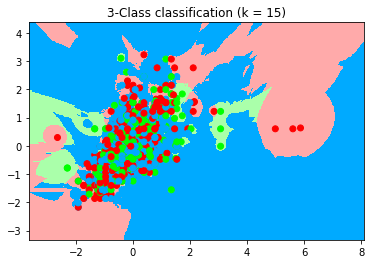

In [18]:
import matplotlib


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn import preprocessing

n_neighbors = 15

le = preprocessing.LabelEncoder()
label = le.fit_transform(df1a.iloc[:, 0:1].values)
# take two features
X = df1a.iloc[:, 27:29].values
y = label
h = 0.02 # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00','#00AAFF'])

# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(X, y)
# calculate min, max and limits
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
np.arange(y_min, y_max, h))

# predict class using data and kNN classifier
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i)" % (n_neighbors))
plt.show()

In [42]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

le = preprocessing.LabelEncoder()
label = le.fit_transform(df1a.iloc[:, 0:1].values)
# take all features
X = df1a.iloc[:, 1:42].values
y = label

Xtrain, Xtest, y_train, y_test = train_test_split(X, y)
scaler = preprocessing.StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

knn = neighbors.KNeighborsClassifier(n_neighbors=4)
knn.fit(Xtrain, y_train)
y_pred = knn.predict(Xtest)

print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.3831417624521073


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Testing with DF2

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


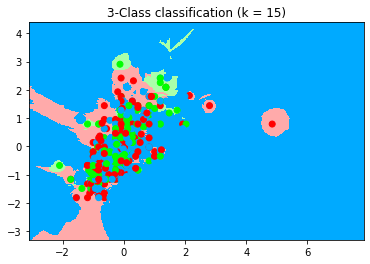

In [43]:
import matplotlib


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn import preprocessing

n_neighbors = 15

le = preprocessing.LabelEncoder()
label = le.fit_transform(df2a.iloc[:, 0:1].values)
# take two features
X = df2a.iloc[:, 27:29].values
y = label
h = 0.02 # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00','#00AAFF'])

# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(X, y)
# calculate min, max and limits
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
np.arange(y_min, y_max, h))

# predict class using data and kNN classifier
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i)" % (n_neighbors))
plt.show()

In [40]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

le = preprocessing.LabelEncoder()
label = le.fit_transform(df2a.iloc[:, 0:1].values)
# take all features
X = df2a.iloc[:, 1:42].values
y = label
Xtrain, Xtest, y_train, y_test = train_test_split(X, y)
scaler = preprocessing.StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

knn = neighbors.KNeighborsClassifier(n_neighbors=4)
knn.fit(Xtrain, y_train)
y_pred = knn.predict(Xtest)

print('Accuracy: ',accuracy_score(y_test, y_pred))

Accuracy:  0.43902439024390244


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# **DF3**

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


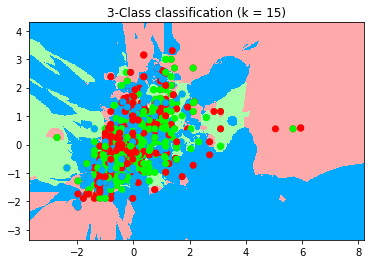

In [44]:
import matplotlib


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn import preprocessing

n_neighbors = 15

le = preprocessing.LabelEncoder()
label = le.fit_transform(df3a.iloc[:, 0:1].values)
# take two features
X = df3a.iloc[:, 27:29].values
y = label
h = 0.02 # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00','#00AAFF'])

# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(X, y)
# calculate min, max and limits
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
np.arange(y_min, y_max, h))

# predict class using data and kNN classifier
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i)" % (n_neighbors))
plt.show()

In [39]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

le = preprocessing.LabelEncoder()
label = le.fit_transform(df3a.iloc[:, 0:1].values)
# take all features
X = df3a.iloc[:, 1:].values
y = label

Xtrain, Xtest, y_train, y_test = train_test_split(X, y)
scaler = preprocessing.StandardScaler().fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

knn = neighbors.KNeighborsClassifier(n_neighbors=4)
knn.fit(Xtrain, y_train)
y_pred = knn.predict(Xtest)

print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.2581453634085213


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
